# Tutorial on ASR inference and alignment with CTC model 
Let's play with the pre-trained speech recognition model!

Here we provide pre-trained speech recognition model with CTC loss on several open-sourced datasets, details can be found in [Rethinking Evaluation in ASR: Are Our Models Robust Enough?](https://arxiv.org/abs/2010.11745)

## Install `Flashlight`
First we need to install `Flashlight` and its dependencies. `Flashlight` is installed from source, it takes **~16 minutes**. 

For installation out of colab notebook please use [link](https://github.com/flashlight/flashlight#building).

In [ ]:
# First, choose backend to build with
backend = 'CUDA' #@param ["CPU", "CUDA"]
# Clone Flashlight
!git clone https://github.com/flashlight/flashlight.git
# install all dependencies for colab notebook
!source flashlight/scripts/colab/colab_install_deps.sh

Build from current master. Builds the ASR app. Resulting binaries in `/content/flashlight/build/bin/asr`.

If using a GPU Colab runtime, build the CUDA backend; else build the CPU backend.

In [ ]:
# export necessary env variables
%env MKLROOT=/opt/intel/mkl
%env ArrayFire_DIR=/opt/arrayfire/share/ArrayFire/cmake
%env DNNL_DIR=/opt/dnnl/dnnl_lnx_2.0.0_cpu_iomp/lib/cmake/dnnl

if backend == "CUDA":
  # Total time: ~13 minutes
  !cd flashlight && git checkout d2e1924cb2a2b32b48cc326bb7e332ca3ea54f67 && mkdir -p build && cd build && \
  cmake .. -DCMAKE_BUILD_TYPE=Release \
           -DFL_BUILD_TESTS=OFF \
           -DFL_BUILD_EXAMPLES=OFF \
           -DFL_BUILD_APP_ASR=ON && \
  make -j$(nproc)
elif backend == "CPU":
  # Total time: ~14 minutes
  !cd flashlight && git checkout d2e1924cb2a2b32b48cc326bb7e332ca3ea54f67 && mkdir -p build && cd build && \
  cmake .. -DFL_ARRAYFIRE_USE_CPU=ON \
           -DFL_USE_ARRAYFIRE=ON \
           -DCMAKE_BUILD_TYPE=Release \
           -DFL_BUILD_TESTS=OFF \
           -DFL_BUILD_EXAMPLES=OFF \
           -DFL_BUILD_APP_ASR=ON && \
  make -j$(nproc)
else:
  raise ValueError(f"Unknown backend {backend}")


Let's take a look around.

In [ ]:
# Binaries are located in
!ls flashlight/build/bin/asr

fl_asr_align   fl_asr_tutorial_finetune_ctc
fl_asr_decode  fl_asr_tutorial_inference_ctc
fl_asr_test    fl_asr_voice_activity_detection_ctc
fl_asr_train


## Inference Step 0: Preparation


### Download Models
Download acoustic model, language model, tokens (defines predicted tokens) and lexicon (defines mapping between words and tokens sequence and used to restrict the beam search only to infer words from the lexicon) files.

In [ ]:
!wget https://dl.fbaipublicfiles.com/wav2letter/rasr/tutorial/am_transformer_ctc_stride3_letters_300Mparams.bin
!wget https://dl.fbaipublicfiles.com/wav2letter/rasr/tutorial/am_conformer_ctc_stride3_letters_25Mparams.bin
!wget https://dl.fbaipublicfiles.com/wav2letter/rasr/tutorial/tokens.txt
!wget https://dl.fbaipublicfiles.com/wav2letter/rasr/tutorial/lexicon.txt
!wget https://dl.fbaipublicfiles.com/wav2letter/rasr/tutorial/lm_common_crawl_small_4gram_prun0-6-15_200kvocab.bin
!mkdir audio
for i in range(5):
  path = "https://dl.fbaipublicfiles.com/wav2letter/rasr/tutorial/audio/116-288045-000{}.flac".format(i)
  !cd audio && wget $path

--2020-12-31 03:39:43--  https://dl.fbaipublicfiles.com/wav2letter/rasr/tutorial/am_transformer_ctc_stride3_letters_300Mparams.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2147270937 (2.0G) [application/octet-stream]
Saving to: ‘am_transformer_ctc_stride3_letters_300Mparams.bin’

am_transformer_ctc_ 100%[===================>]   2.00G  26.7MB/s    in 78s     

2020-12-31 03:41:01 (26.3 MB/s) - ‘am_transformer_ctc_stride3_letters_300Mparams.bin’ saved [2147270937/2147270937]

--2020-12-31 03:41:01--  https://dl.fbaipublicfiles.com/wav2letter/rasr/tutorial/am_conformer_ctc_stride3_letters_25Mparams.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9

### Install dependencies to record/process audio

In [ ]:
!apt-get install sox
!pip install ffmpeg-python sox

### Helper functions for inference

Define helper functions to run inference binary as subprocess

In [ ]:
import os
import signal
from subprocess import Popen, PIPE  


def read_current_output(process):
    while True:
        output = process.stderr.readline()
        print(output.decode().strip())
        if "Waiting the input in the format" in output.decode():
          break;


def create_process(cmd):
    process = Popen([cmd],
                    stdin=PIPE, stdout=PIPE, stderr=PIPE,
                    shell=True, preexec_fn=os.setsid) 
    read_current_output(process)
    return process


def run_inference(audio_path, process):
    process.stdin.write("{}\n".format(audio_path).encode())
    process.stdin.flush()
    read_current_output(process)

### Run the inference process with a model

We are using best parameters we found on validation sets of training data with a language model we provide in this tutorial. You can play with `beam_size` (increasing it, but inference time will increse too), `lm_weight` and `word_score`

In [ ]:
# you can switch here to small model am_conformer_ctc_stride3_letters_25Mparams.bin
# set for it also lm_weight=2 and word_score=0
inference_cmd = """./flashlight/build/bin/asr/fl_asr_tutorial_inference_ctc \
  --am_path=am_transformer_ctc_stride3_letters_300Mparams.bin \
  --tokens_path=tokens.txt \
  --lexicon_path=lexicon.txt \
  --lm_path=lm_common_crawl_small_4gram_prun0-6-15_200kvocab.bin \
  --logtostderr=true \
  --sample_rate=16000 \
  --beam_size=50 \
  --beam_size_token=30 \
  --beam_threshold=100 \
  --lm_weight=1.5 \
  --word_score=0"""
inference_process = create_process(inference_cmd)

I1231 04:02:21.275265  9446 InferenceCTC.cpp:65] Gflags after parsing
--flagfile=;--fromenv=;--tryfromenv=;--undefok=;--tab_completion_columns=80;--tab_completion_word=;--help=false;--helpfull=false;--helpmatch=;--helpon=;--helppackage=false;--helpshort=false;--helpxml=false;--version=false;--am_path=am_transformer_ctc_stride3_letters_300Mparams.bin;--audio_list=;--beam_size=50;--beam_size_token=30;--beam_threshold=100;--lexicon_path=lexicon.txt;--lm_path=lm_common_crawl_small_4gram_prun0-6-15_200kvocab.bin;--lm_weight=1.5;--sample_rate=16000;--tokens_path=tokens.txt;--word_score=0;--alsologtoemail=;--alsologtostderr=false;--colorlogtostderr=false;--drop_log_memory=true;--log_backtrace_at=;--log_dir=;--log_link=;--log_prefix=true;--logbuflevel=0;--logbufsecs=30;--logemaillevel=999;--logfile_mode=436;--logmailer=/bin/mail;--logtostderr=true;--max_log_size=1800;--minloglevel=0;--stderrthreshold=2;--stop_logging_if_full_disk=false;--symbolize_stacktrace=true;--v=0;--vmodule=;
I1231 04:02:

## Inference Step 1: Record Audio from Your Microphone and Run Inference




### Let's record!

In [ ]:
from flashlight.scripts.colab.record import record_audio
record_audio("recorded_audio")

output_file: recorded_audio.wav already exists and will be overwritten on build


### Let's run inference on the audio file you have just recorded

In [ ]:
run_inference("recorded_audio.wav", inference_process)

I1231 04:02:41.062546  9446 InferenceCTC.cpp:284] [Inference tutorial for CTC]: predicted output for recorded_audio.wav
happy new year
I1231 04:02:41.062593  9446 InferenceCTC.cpp:233] [Inference tutorial for CTC]: Waiting the input in the format [audio_path].


### Finish the process to release memory

You can skip if you still want to use this process

In [ ]:
os.killpg(os.getpgid(inference_process.pid), signal.SIGTERM)

## Inference Step 2: Run on a Set of Audio Files Provided in the txt File



### Prepare the file with all audio paths at first

In [ ]:
!ls audio/*.flac > audio.lst

In [ ]:
!cat audio.lst

audio/116-288045-0000.flac
audio/116-288045-0001.flac
audio/116-288045-0002.flac
audio/116-288045-0003.flac
audio/116-288045-0004.flac


### Run inference on all audio files from this list

In [ ]:
!./flashlight/build/bin/asr/fl_asr_tutorial_inference_ctc \
  --am_path=am_transformer_ctc_stride3_letters_300Mparams.bin \
  --tokens_path=tokens.txt \
  --lexicon_path=lexicon.txt \
  --lm_path=lm_common_crawl_small_4gram_prun0-6-15_200kvocab.bin \
  --logtostderr=true \
  --sample_rate=16000 \
  --beam_size=50 \
  --beam_size_token=30 \
  --beam_threshold=100 \
  --lm_weight=1.5 \
  --word_score=0 \
  --audio_list=audio.lst

I1231 04:00:26.450810  9424 InferenceCTC.cpp:65] Gflags after parsing
--flagfile=;--fromenv=;--tryfromenv=;--undefok=;--tab_completion_columns=80;--tab_completion_word=;--help=false;--helpfull=false;--helpmatch=;--helpon=;--helppackage=false;--helpshort=false;--helpxml=false;--version=false;--am_path=am_transformer_ctc_stride3_letters_300Mparams.bin;--audio_list=audio.lst;--beam_size=50;--beam_size_token=30;--beam_threshold=100;--lexicon_path=lexicon.txt;--lm_path=lm_common_crawl_small_4gram_prun0-6-15_200kvocab.bin;--lm_weight=1.5;--sample_rate=16000;--tokens_path=tokens.txt;--word_score=0;--alsologtoemail=;--alsologtostderr=false;--colorlogtostderr=false;--drop_log_memory=true;--log_backtrace_at=;--log_dir=;--log_link=;--log_prefix=true;--logbuflevel=0;--logbufsecs=30;--logemaillevel=999;--logfile_mode=436;--logmailer=/bin/mail;--logtostderr=true;--max_log_size=1800;--minloglevel=0;--stderrthreshold=2;--stop_logging_if_full_disk=false;--symbolize_stacktrace=true;--v=0;--vmodule=;
I12

## Alignment Step 1: Voice Activity Detection (VAD)

### Prepare files

Prepare first the list of files in the format `[id path duration(s)]`

In [ ]:
import sox
with open("vad.lst", "w") as fout, open("audio.lst", "r") as f:
  for n, name in enumerate(f):
    name = name.strip()
    fout.write("{}\t{}\t{}\n".format(
        n, name, sox.file_info.duration(name)))

In [ ]:
!head vad.lst

0	audio/116-288045-0000.flac	10.65
1	audio/116-288045-0001.flac	8.635
2	audio/116-288045-0002.flac	9.625
3	audio/116-288045-0003.flac	3.66
4	audio/116-288045-0004.flac	3.72


### Helper function to plot result

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy


def plot_vad(filename, predicted_token_transcription):
    plt.figure(figsize=(20, 15))
    
    y, sample_rate = librosa.load(filename, sr=None)
    ax1 = plt.subplot(211)
    librosa.display.waveplot(y, sr=sample_rate)
    plt.title(filename)
    plt.xlabel("Time (s)")
  
    n_fft = 512
    # corresponds to 10ms stride 
    hop_length = sample_rate // 100
    # win_length corresponds to 25ms window
    win_length = int(hop_length * 2.5)
    D = numpy.abs(librosa.stft(
        y, n_fft=n_fft, hop_length=hop_length, win_length=win_length))
    DB = librosa.amplitude_to_db(D, ref=numpy.max)
    ax2 = plt.subplot(212)
    librosa.display.specshow(
        DB, sr=sample_rate, hop_length=hop_length, x_axis='s', y_axis='log');

    model_stride = numpy.ceil(DB.shape[1] / len(transcription))
    positions = []
    values = []
    for n, t in enumerate(transcription):
      if t != "#": # skip blanks
        plt.axvline(x=n * model_stride / 100, label=t, linewidth=0.5, linestyle='-')
         # converting frames into seconds with respect to 10ms fft
        positions.append(n * model_stride / 100)
        values.append(t)

    plt.xticks(positions, values, fontsize=14)
    plt.show()

### Let's run VAD

In [ ]:
# lm can be skipped, then no perplexity value wil be in the result file
!./flashlight/build/bin/asr/fl_asr_voice_activity_detection_ctc \
   --am=am_transformer_ctc_stride3_letters_300Mparams.bin \
   --tokens=tokens.txt \
   --lexicon=lexicon.txt \
   --lm=lm_common_crawl_small_4gram_prun0-6-15_200kvocab.bin \
   --test=vad.lst \
   --outpath=vad-result

I1231 07:51:02.373100 14532 VoiceActivityDetection-CTC.cpp:115] Gflags after parsing 
--flagfile=; --fromenv=; --tryfromenv=; --undefok=; --tab_completion_columns=80; --tab_completion_word=; --help=false; --helpfull=false; --helpmatch=; --helpon=; --helppackage=false; --helpshort=false; --helpxml=false; --version=false; --adambeta1=0.94999999999999996; --adambeta2=0.98999999999999999; --am=am_transformer_ctc_stride3_letters_300Mparams.bin; --am_decoder_tr_dropout=0.20000000000000001; --am_decoder_tr_layerdrop=0.20000000000000001; --am_decoder_tr_layers=6; --arch=EG_GLU1x2048_S3_TR36x768_DO0.1_LD0.1_CTC; --attention=keyvalue; --attentionthreshold=2147483647; --attnWindow=softPretrain; --attnconvchannel=0; --attnconvkernel=0; --attndim=0; --batching_max_duration=0; --batching_strategy=none; --batchsize=3; --beamsize=2500; --beamsizetoken=250000; --beamthreshold=25; --channels=1; --criterion=ctc; --critoptim=adagrad; --datadir=; --decoderattnround=1; --decoderdropout=0; --decoderrnnlayer=

### Check VAD result

Let's have a look at results we have in the `outpath` directory

**Note:** number of frames for which we provide predictions is equal to `duration(seconds) * 1000 / stride(ms) / model_stride`, where stride is often 10ms for mfsc/mfcc features computation and model_stride in the example is 3.

In [ ]:
!ls vad-result/

0.fwt  0.tsc  1.fwt  1.tsc  2.fwt  2.tsc  3.fwt  3.tsc	4.fwt  4.tsc
0.sts  0.vad  1.sts  1.vad  2.sts  2.vad  3.sts  3.vad	4.sts  4.vad


In [ ]:
# id, percent of voice frames, perplexity of the transcription
!head vad-result/3.sts

3 0.729508 203.997


In [ ]:
# final transcription
!head vad-result/3.tsc

we|gazed|for|a|moment|slightly|into|each|other's|eyes


In [ ]:
# per-frame transcription (# - is a blank token)
!head vad-result/3.fwt

# # # # # # # # # # # # # # w e # # | | | g # a # # z # # e d | | | | f o r | | | a | | # m o # m e n n t # | | s s l i g h h t # l l y | i n n t t o | | e a c h | | o t t h e r ' ' s | | e y y e e s # # # # # # # # # # # # # # # | | | | | | | 


In [ ]:
# per-frame blank confidence
!head vad-result/3.vad

1 1 1 1 1 1 1 1 1 1 1 1 1 0.9692 1.851e-06 7.071e-07 0.9992 0.9956 0.000347 9.418e-08 0.004056 1.265e-09 0.9598 2.07e-09 0.9994 1 1.585e-07 1 0.946 9.62e-07 2.545e-05 0.01153 2.329e-08 1.906e-08 5.656e-05 7.519e-07 7.305e-08 2.647e-07 0.1134 2.045e-06 5.101e-05 3.327e-07 0.001338 5.414e-06 0.701 2.915e-06 7.458e-06 0.6109 4.004e-06 1.721e-06 4.843e-06 0.3823 2.16e-06 0.9958 0.0154 1.577e-06 0.0005334 0.1442 4.669e-07 9.158e-07 1.317e-05 0.3291 0.0001441 1.886e-05 1 0.1014 0.003936 3.245e-05 6.148e-06 6.846e-05 0.001841 0.09762 0.1137 0.0006082 0.0004298 5.446e-05 0.002452 3.336e-06 4.798e-06 2.937e-06 1.274e-05 0.05504 3.879e-05 4.552e-06 4.608e-06 0.04145 1.321e-06 5.559e-07 4.767e-06 0.1119 0.07716 0.000276 0.005523 0.0005636 4.705e-05 0.0005873 0.009057 0.01866 3.81e-05 0.01305 0.9539 1 1 1 1 1 1 1 1 1 1 1 1 1 0.9817 7.905e-09 8.7e-10 1.271e-08 3.384e-08 1.847e-08 4.554e-08 0.00076 


**Result of VAD can be used to cut an audio into chunks for faster training/processing**

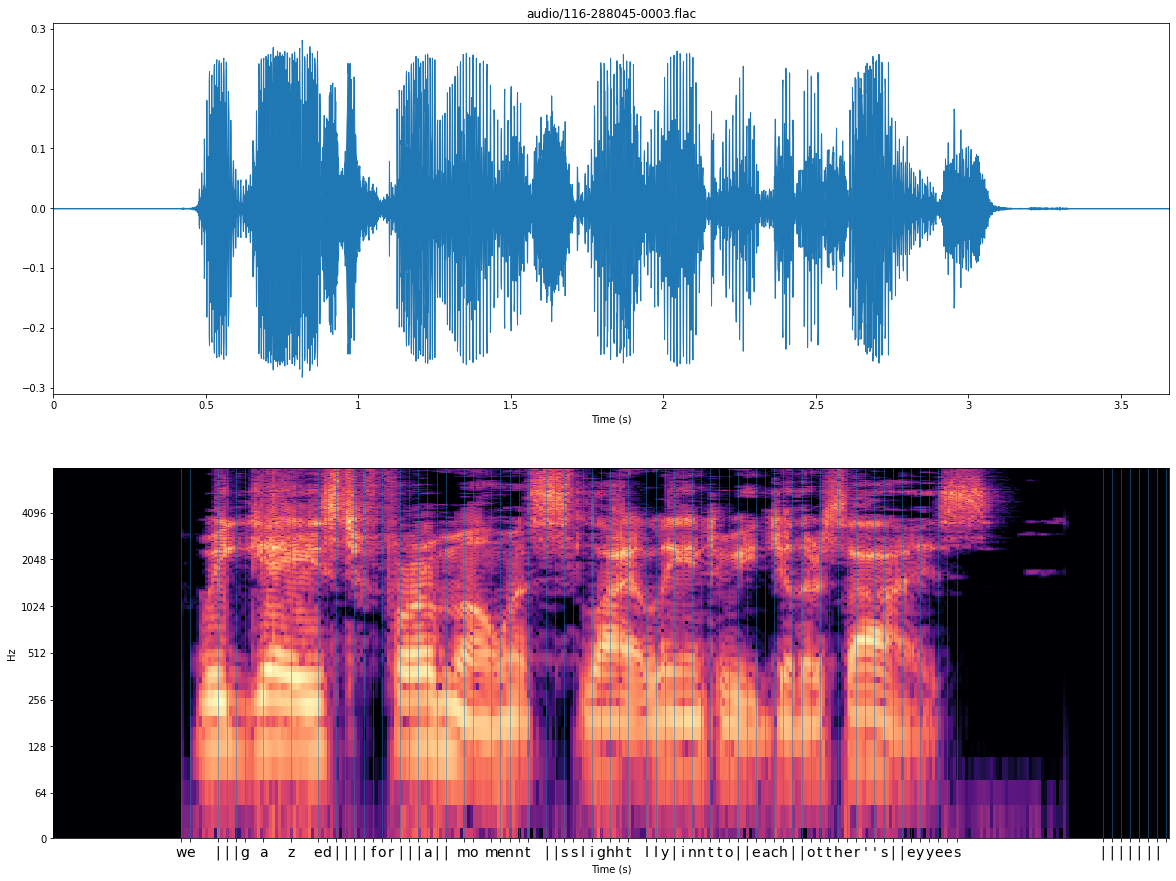

In [ ]:
with open("vad-result/3.fwt", "r") as f:
  plot_vad("audio/116-288045-0003.flac", f.readline().strip())

## Alignment Step 2: Align

### Prepare files

Prepare first the list of files and its original transcriptions in the format `[id path duration(s) transcription]`

In [ ]:
import sox
transcriptions = [
                  "as i approached the city i heard bells ringing and a little later i found the streets astir with throngs of well dressed people in family groups wending their way hither and thither",
                  "looking about me i saw a gentleman in a neat black dress smiling and his hand extended to me with great cordiality",
                  "he must have realized i was a stranger and wished to tender his hospitality to me i accepted it gratefully i clasped his hand he pressed mine",
                  "we gazed for a moment silently into each other's eyes",
                  "of course you are going there too i said to my friendly guide"
                  ]
with open("align.lst", "w") as fout, open("audio.lst", "r") as f:
  for n, name in enumerate(f):
    name = name.strip()
    fout.write("{}\t{}\t{}\t{}\n".format(
        name, name, sox.file_info.duration(name), transcriptions[n]))

In [ ]:
!head align.lst

audio/116-288045-0000.flac	audio/116-288045-0000.flac	10.65	as i approached the city i heard bells ringing and a little later i found the streets astir with throngs of well dressed people in family groups wending their way hither and thither
audio/116-288045-0001.flac	audio/116-288045-0001.flac	8.635	looking about me i saw a gentleman in a neat black dress smiling and his hand extended to me with great cordiality
audio/116-288045-0002.flac	audio/116-288045-0002.flac	9.625	he must have realized i was a stranger and wished to tender his hospitality to me i accepted it gratefully i clasped his hand he pressed mine
audio/116-288045-0003.flac	audio/116-288045-0003.flac	3.66	we gazed for a moment silently into each other's eyes
audio/116-288045-0004.flac	audio/116-288045-0004.flac	3.72	of course you are going there too i said to my friendly guide


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy


def plot_align(filename, align_result):
    plt.figure(figsize=(20, 10))

    y, sample_rate = librosa.load(filename, sr=None)
    ax1 = plt.subplot(211)
    librosa.display.waveplot(y, sr=sample_rate)
    plt.title(filename)
    plt.xlabel("Time (s)")

    positions = []
    values = []
    for alt in align_result:
      _, _, start_time, duration, token = alt.split(" ")
      duration = float(duration)
      start_time = float(start_time)
      plt.axvline(start_time, label=token, linewidth=0.5, linestyle='-', color="grey")
      positions.append(start_time + duration / 2)
      values.append(token)

    plt.xticks(positions, values, fontsize=12)
    plt.show()

### Let's run Align

In [ ]:
# lm can be skipped, then no perplexity value wil be in result
!./flashlight/build/bin/asr/fl_asr_align result.align\
   --am=am_transformer_ctc_stride3_letters_300Mparams.bin \
   --tokens=tokens.txt \
   --lexicon=lexicon.txt \
   --test=align.lst

I1231 07:51:16.668932 14569 Align.cpp:76] Gflags after parsing 
--flagfile=; --fromenv=; --tryfromenv=; --undefok=; --tab_completion_columns=80; --tab_completion_word=; --help=false; --helpfull=false; --helpmatch=; --helpon=; --helppackage=false; --helpshort=false; --helpxml=false; --version=false; --adambeta1=0.94999999999999996; --adambeta2=0.98999999999999999; --am=am_transformer_ctc_stride3_letters_300Mparams.bin; --am_decoder_tr_dropout=0.20000000000000001; --am_decoder_tr_layerdrop=0.20000000000000001; --am_decoder_tr_layers=6; --arch=EG_GLU1x2048_S3_TR36x768_DO0.1_LD0.1_CTC; --attention=keyvalue; --attentionthreshold=2147483647; --attnWindow=softPretrain; --attnconvchannel=0; --attnconvkernel=0; --attndim=0; --batching_max_duration=0; --batching_strategy=none; --batchsize=3; --beamsize=2500; --beamsizetoken=250000; --beamthreshold=25; --channels=1; --criterion=ctc; --critoptim=adagrad; --datadir=; --decoderattnround=1; --decoderdropout=0; --decoderrnnlayer=1; --decodertype=wrd; 

### Check align result

In [ ]:
!head result.align

audio/116-288045-0000.flac	ID A 0 0.479099 #\nID A 0.479099 0.0299437 a\nID A 0.509042 0.0299437 s\nID A 0.538986 0.0299437 #\nID A 0.56893 0.0598873 |\nID A 0.628817 0.0598873 i\nID A 0.688704 0.119775 |\nID A 0.808479 0.0299437 a\nID A 0.838423 0.0299437 p\nID A 0.868366 0.0598873 #\nID A 0.928254 0.0299437 p\nID A 0.958197 0.0299437 #\nID A 0.988141 0.0299437 r\nID A 1.01808 0.0299437 o\nID A 1.04803 0.0299437 a\nID A 1.07797 0.0299437 c\nID A 1.10792 0.0299437 h\nID A 1.13786 0.0299437 #\nID A 1.1678 0.0299437 e\nID A 1.19775 0.0299437 d\nID A 1.22769 0.0598873 |\nID A 1.28758 0.0299437 t\nID A 1.31752 0.0299437 h\nID A 1.34746 0.0299437 e\nID A 1.37741 0.089831 |\nID A 1.46724 0.0299437 c\nID A 1.49718 0.0299437 i\nID A 1.52713 0.0299437 #\nID A 1.55707 0.0299437 t\nID A 1.58701 0.0299437 #\nID A 1.61696 0.0299437 y\nID A 1.6469 0.0598873 #\nID A 1.70679 0.149718 |\nID A 1.85651 0.0299437 i\nID A 1.88645 0.119775 |\nID A 2.00623 0.0598873 h\nID A 2.06611 0.0299437 e\nID A 2.09606 

In [ ]:
aling_result = dict()
with open("result.align", "r") as f:
  for line in f:
    sample_id, alignment = line.strip().split("\t")
    aling_result[sample_id] = alignment.split("\\n")

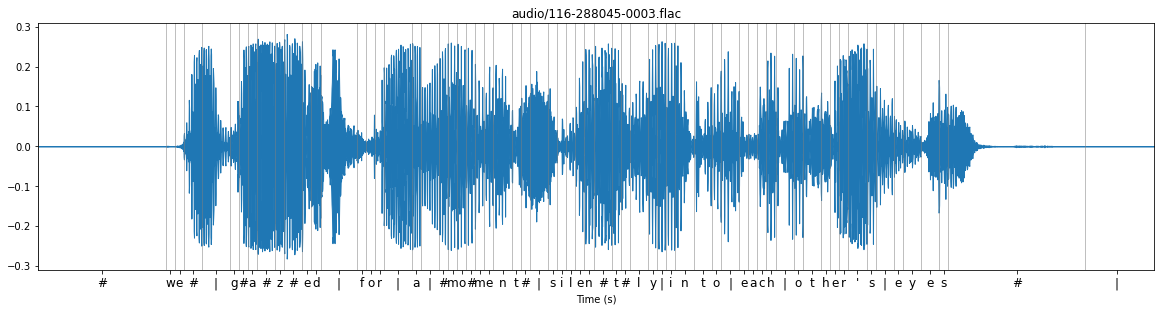

In [ ]:
plot_align("audio/116-288045-0003.flac", aling_result["audio/116-288045-0003.flac"])

## Congrats, you reached the end!
![title](https://media1.giphy.com/media/3otPoS81loriI9sO8o/giphy.gif)
## Happy New Year!
